<h1 align='center'> Modelo Quarter-Car como um Sistema Linear Invariante no Tempo </h1>

In [1]:
#Importando bibliotecas:
import numpy as np
import control as ct
import warnings
import matplotlib.pyplot as plt
import scienceplots

warnings.filterwarnings("ignore")

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 20

title = False

#Exibição dos gráficos em no notebook:
%matplotlib inline

'''
#Exibição dos gráficos em janela externa:
%matplotlib qt
'''

def mag2db(mag):
    return (20*np.log10(mag))

### Parâmetros do sistema:

In [2]:
# Unidades no S.I [m, Kg, N/m, Kg*m², (N*s)/m]:
# GDL não suspenso dianteiro:
a1 = 1.17
m1 = 100
kt1 = 300000

# GDL não suspenso traseiro:
a2 = 1.68
m2 = 100
kt2 = 300000

# GDL suspenso:
Iy = (1100/2)
ms = (840/2)
k1 = 30000
k2 = 30000
c1 = 500
c2 = 500

### Definição das matrizes $$[M],~[C],~[K]$$ e condições iniciais:

In [3]:
# Fator de correção para cálculos:
fc = 1e0

# Matriz das massas (Kg):
M = np.array([
    [ms, 0, 0, 0],
    [0, Iy, 0, 0],
    [0, 0, m1, 0],
    [0, 0, 0, m2]
], dtype=float)*fc

# Matriz de amortecimento (N*s/m):
C = np.array([
    [(c1+c2), ((a2*c2)-(a1*c1)), -c1, -c2],
    [((a2*c2)-(a1*c1)), ((c1*(a1**2))+(c2*(a2**2))), (a1*c1), -(a2*c2)],
    [-c1, (a1*c1), c1, 0],
    [-c2, -(a2*c2), 0, c2]
], dtype=float)*fc

# Matriz de rigidez (N/m):
K = np.array([
    [(k1+k2), ((a2*k2)-(a1*k1)), -k1, -k2],
    [((a2*k2)-(a1*k1)), ((k1*(a1**2))+(k2*(a2**2))), (a1*k1), -(a2*k2)],
    [-k1, (a1*k1), (k1+kt1), 0],
    [-k2, -(a2*k2), 0, (k2+kt2)]
], dtype=float)*fc

# Matriz de posições iniciais (transposta):
X0 = np.array([0, 0, 0, 0], dtype=float).T

# Matriz de velocidades iniciais (transposta):
V0 = np.array([0, 0, 0, 0], dtype=float).T

### Montando o LTI no formato $$\dot{[X]} = [A][X]+[B][U] ~~~~ e ~~~~ [Y] = [C][X] + [D][U]:$$

In [4]:
N = len(M)

A = np.block([
    [np.zeros((N, N)), np.eye(N)],
    [-np.linalg.inv(M)@K, -np.linalg.inv(M)@C]
])

B = np.block([
    [np.zeros((6, 2))],
    [np.array([
        [(kt1/m1), 0], 
        [0, (kt2/m2)]
    ])]
])

C = np.block([
    [np.eye(N), np.zeros((N, N))],
    [np.zeros((N, 2*N))]
])

D = np.zeros((2*N, 2))

system = ct.ss(A, B, C, D)

### Excitação externa por perfil de pista:

##### Entrada Harmônica:

In [5]:


# Tempo de amostragem:
ts = 1e-2

# Tempo de simulação:
tf = 80

# Velocidade do carro em Km/h:
v_car = 18

# Amplitude em mm:
amplitude = 250

# Espaçamento em m:
esp = 100

# Offset em mm:
offset = 0

# Função de entrada de deslocamento, em mm:
freq = round(((v_car*2*np.pi)/(3.6*esp)), 4)

phi_t = round(((a1+a2)/v_car), 4)
phi_d = 0

def ent(t, fase):
    return (((amplitude*np.sin((t*freq)+fase))+offset)*1e-3)

# Criação do vetor de tempo:
tfa = 500
if (tf > tfa):
    tfa = tf
time = np.arange(0, tfa, ts)

ut = ent(time, phi_t)
ud = ent(time, phi_d)

##### Dados empíricos:

In [6]:


'''
# Leitura do arquivo:
ts = 1e-2
arq = open('data.txt', 'r')
g = []
for linha in arq:
    linha = arq.readline()
    if(linha != ''):
        g.append(float(linha))
arq.close()
def actopos(dados):
    v_ant = 0
    current_t = [0]
    current_pos = [0]
    for i in range(len(dados)):
        current_pos.append(round((current_pos[i]+(v_ant*ts)+(dados[i]*(ts**2))), 4))
        current_t.append(ts*(i+1))
    return current_t, current_pos
time, y = actopos(np.multiply(g, (9.8067*1e3)))
tf = np.max(time)
'''

# INCOMLPETO! - Tem que encontrar uma forma de ajustar uma função que atenda sinais senoidais, como soma de senos e cossenos a partir de uma amostra....

"\n# Leitura do arquivo:\nts = 1e-2\narq = open('data.txt', 'r')\ng = []\nfor linha in arq:\n    linha = arq.readline()\n    if(linha != ''):\n        g.append(float(linha))\narq.close()\ndef actopos(dados):\n    v_ant = 0\n    current_t = [0]\n    current_pos = [0]\n    for i in range(len(dados)):\n        current_pos.append(round((current_pos[i]+(v_ant*ts)+(dados[i]*(ts**2))), 4))\n        current_t.append(ts*(i+1))\n    return current_t, current_pos\ntime, y = actopos(np.multiply(g, (9.8067*1e3)))\ntf = np.max(time)\n"

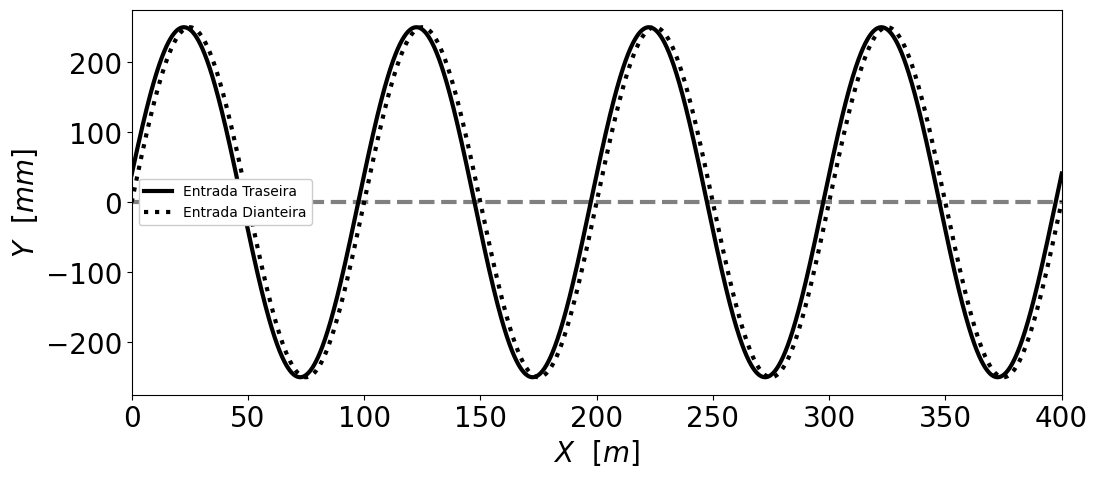

In [7]:
# Plotando os gráficos:
plt.rcParams['figure.figsize'] = (12, 5)
plt.figure()
plt.plot((0, (tf*v_car/3.6)), (0, 0), 'gray', linestyle='dashed')
plt.plot((time*v_car/3.6), (ut*1e3), 'k', label='Entrada Traseira')
plt.plot((time*v_car/3.6), (ud*1e3), 'k', linestyle='dotted', label='Entrada Dianteira')
plt.ylabel('$Y~~[mm]$')
plt.xlabel('$X~~[m]$')
plt.xlim(0, (tf*v_car/3.6))
plt.legend(fontsize=10)
if(title):
    plt.title('Perfil da Pista')
plt.grid()
plt.savefig('curves/road_LTI.eps', dpi=600, transparent=True, bbox_inches='tight')

### Encontrando as Frequências Naturais:

In [8]:
# Cálculo de M^(-1/2):
MM = np.power(M, -1/2)  # Inverso da raíz quadrada
MM[MM == np.inf] = 0  # Transforma os elementos infinitos em zero

ktil = MM@K@MM  # Cálculo da matriz ktil 
lamb, p = np.linalg.eig(ktil) # Obtenção dos autovalores

omega_n = np.sqrt(lamb)

labels = ['s', 't', '1', '2']
for i in range(len(omega_n)):
    print(f'w{labels[i]} = {round((omega_n[i]), 4)} rad/s')

ws = 10.9475 rad/s
wt = 14.6928 rad/s
w1 = 57.5542 rad/s
w2 = 57.6477 rad/s


### Resposta Forçada:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


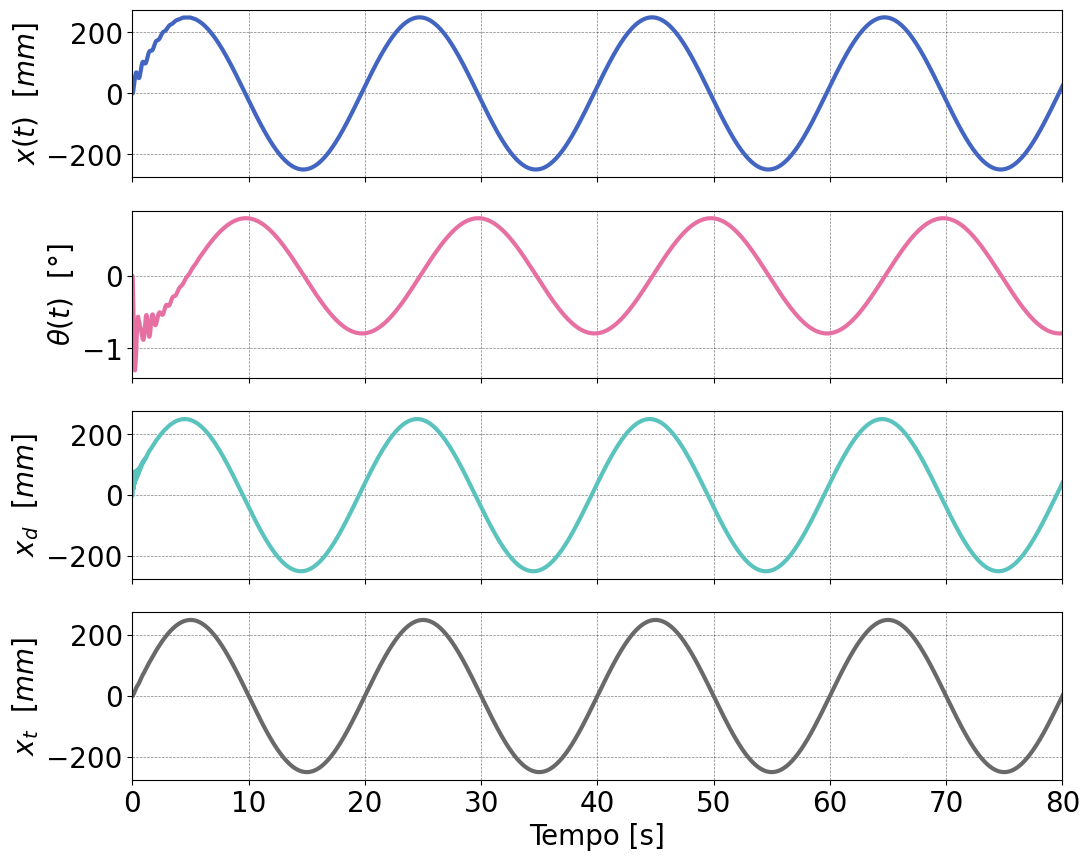

In [9]:
time, y = ct.forced_response(system, T=time, U=(ut, ud), X0=np.block([X0.T, V0.T]))

# Plot dos gráficos:
colors = ['C6', 'C1', 'C2', 'C3']
plt.rcParams['figure.figsize'] = (12, 10)
plt.subplots(4, sharex=True)
labels = ['$x(t)~~[mm]$', '$\\theta(t)~~[°]$', '$x_d~~[mm]$', '$x_t~~[mm]$']
for i in range(4):
    plt.subplot(4, 1, (i+1))
    if(i==1):
        plt.plot(time, np.degrees(y[i]), color=colors[i])
    else:
        plt.plot(time, (y[i]*1e3), color=colors[i])
    plt.ylabel(labels[i])
plt.xlim(0, tf)
plt.xlabel('Tempo [s]')
plt.subplot(4, 1, 1)
if(title):
    plt.title('Resposta Temporal Real')
plt.savefig('curves/TR1_LTI.eps', dpi=600, transparent=True, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


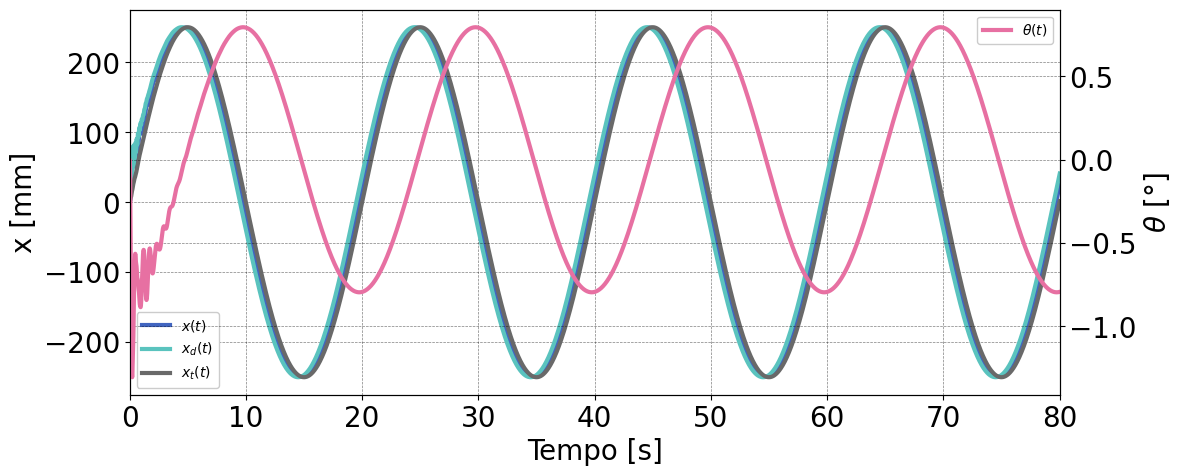

In [10]:
#Plot único:
colors = ['C6', 'C1', 'C2', 'C3']
plt.rcParams['figure.figsize'] = (12, 5)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
labels = ['$x(t)$', '$\\theta(t)$', '$x_d(t)$', '$x_t(t)$']
for i in range(4):
    if(i==1):
        ax2.plot(time, np.degrees(y[i]), color=colors[i], label=labels[i])
    else:
        ax1.plot(time, (y[i]*1e3), colors[i], label=labels[i])
ax1.set_ylabel('x [mm]')
ax2.set_ylabel('$\\theta$ [°]')
ax1.set_xlabel('Tempo [s]')
ax1.legend(loc='lower left', fontsize=10)
ax2.legend(loc='upper right', fontsize=10)
plt.xlim(0, tf)
if(title):
    plt.title('Resposta Temporal Real')
plt.savefig('curves/TR2_LTI.eps', dpi=600, transparent=True, bbox_inches='tight')

### Resposta em Frequência: Diagrama de Bode

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


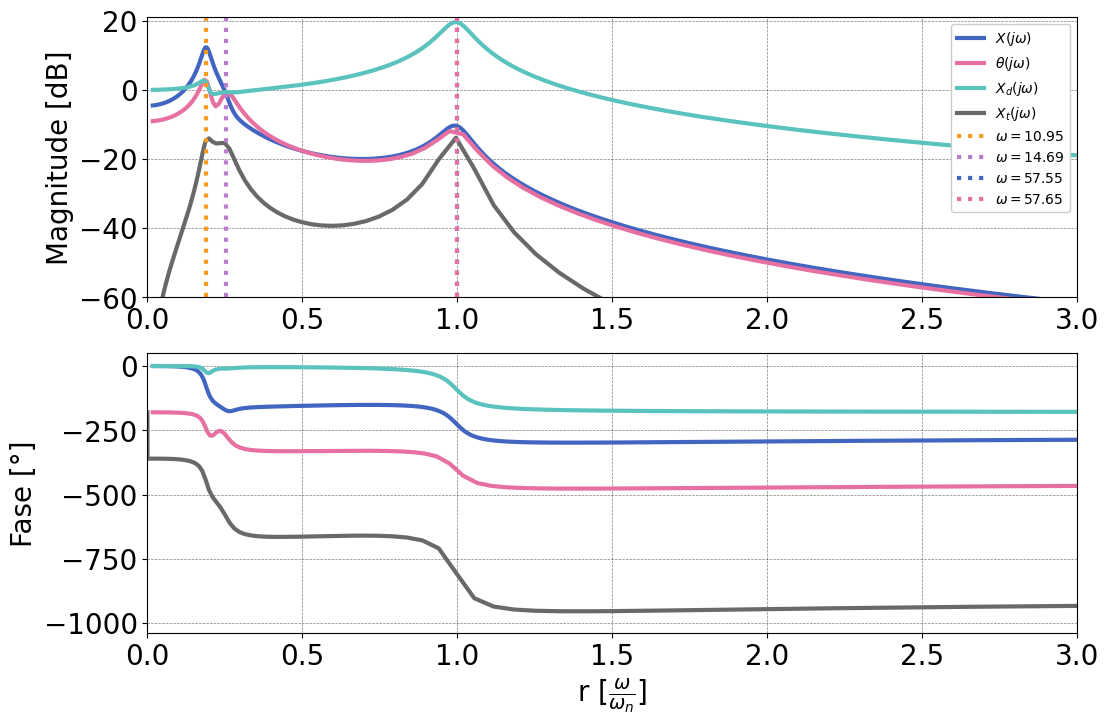

In [11]:
ft = ct.ss2tf(system)
num = ft.num
den = ft.den

bode = []
for i in range(len(omega_n)):
    bode.append(ct.bode(ct.tf(num[i][0], den[i][0]), plot=False))

N = np.max(omega_n)

plt.rcParams['figure.figsize'] = (12, 8)
plt.subplots(len(omega_n), sharex=True)

labels = ['$X(j\omega)$', '$\\theta(j\omega)$', '$X_d(j\omega)$', '$X_t(j\omega)$']
plt.subplot(2, 1, 1)
for i in range(len(omega_n)):
    plt.plot((bode[i][2]/N), mag2db(bode[i][0]), label=labels[i])
for i in range(len(omega_n)):
    plt.plot((omega_n[i]/N, omega_n[i]/N), (-60, 21), linestyle='dotted', label=f'$\omega = {omega_n[i]:.2f}$')
#plt.plot((np.sqrt(2), np.sqrt(2)), (-60, 21), color='pink', linestyle='-.', label='$r = \sqrt{2}$')
plt.xlim(0, 3)
plt.ylim(-60, 21)
plt.ylabel('Magnitude [dB]')
plt.legend(fontsize=10)
plt.subplot(2, 1, 2)
for i in range(len(omega_n)):
    plt.plot((bode[i][2]/N), np.degrees(bode[i][1]))
plt.xlim(0, 3)
plt.xlabel('r [$\\frac{\omega}{\omega_n}$]')
plt.ylabel('Fase [°]')
if(title):
    plt.subplot(len(omega_n), 1, 1)
    plt.title('Resposta em Frequência')
plt.savefig('curves/FR_LTI.eps', dpi=600, transparent=True, bbox_inches='tight')